In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
alxmamaev_flowers_recognition_path = kagglehub.dataset_download('alxmamaev/flowers-recognition')

print('Data source import complete.')


Data source import complete.


# 1) Import Various Modules

In [ ]:
# ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# configure
# sets matplotlib to inline and display graphs below the corress poding cell
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_auc_score,classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy

# specifically for cnn
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.regularizers import l2

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images
import cv2
import numpy as np
import os
from tqdm import tqdm
from zipfile import ZipFile
from PIL import Image


In [ ]:
print(os.listdir('/kaggle/input/flowers-recognition'))

['flowers']


In [ ]:
print(os.listdir('/kaggle/input/flowers-recognition/flowers'))

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


## 2)Preparing the Data

2.1)Making the function to get the training and validation set from the image

In [ ]:
X=[]
Z=[]
IMG_SIZE = 150
FLOWER_DISY_DIR ='/kaggle/input/flowers-recognition/flowers/daisy'
FLOWER_SUNFLOWR_DIR = '/kaggle/input/flowers-recognition/flowers/sunflower'
FLOWER_TULIP_DIR = '/kaggle/input/flowers-recognition/flowers/tulip'
FLOWER_DAND_DIR = '/kaggle/input/flowers-recognition/flowers/dandelion'
FLOWER_ROSE_DIR = '/kaggle/input/flowers-recognition/flowers/rose'

In [ ]:
def assign_label(img,flower_type):
    return flower_type

In [ ]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [ ]:
make_train_data('Daisy',FLOWER_DISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:07<00:00, 107.32it/s]

764


In [ ]:
make_train_data('Sunflower',FLOWER_SUNFLOWR_DIR)
print(len(X))

100%|██████████| 733/733 [00:06<00:00, 107.29it/s]

1497


In [ ]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:09<00:00, 109.14it/s]

2481


In [ ]:
make_train_data('Dandelion',FLOWER_DAND_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:09<00:00, 106.25it/s]

3533


In [ ]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:06<00:00, 112.56it/s]

4317


## 2.2 ) Visualizing some Random Images

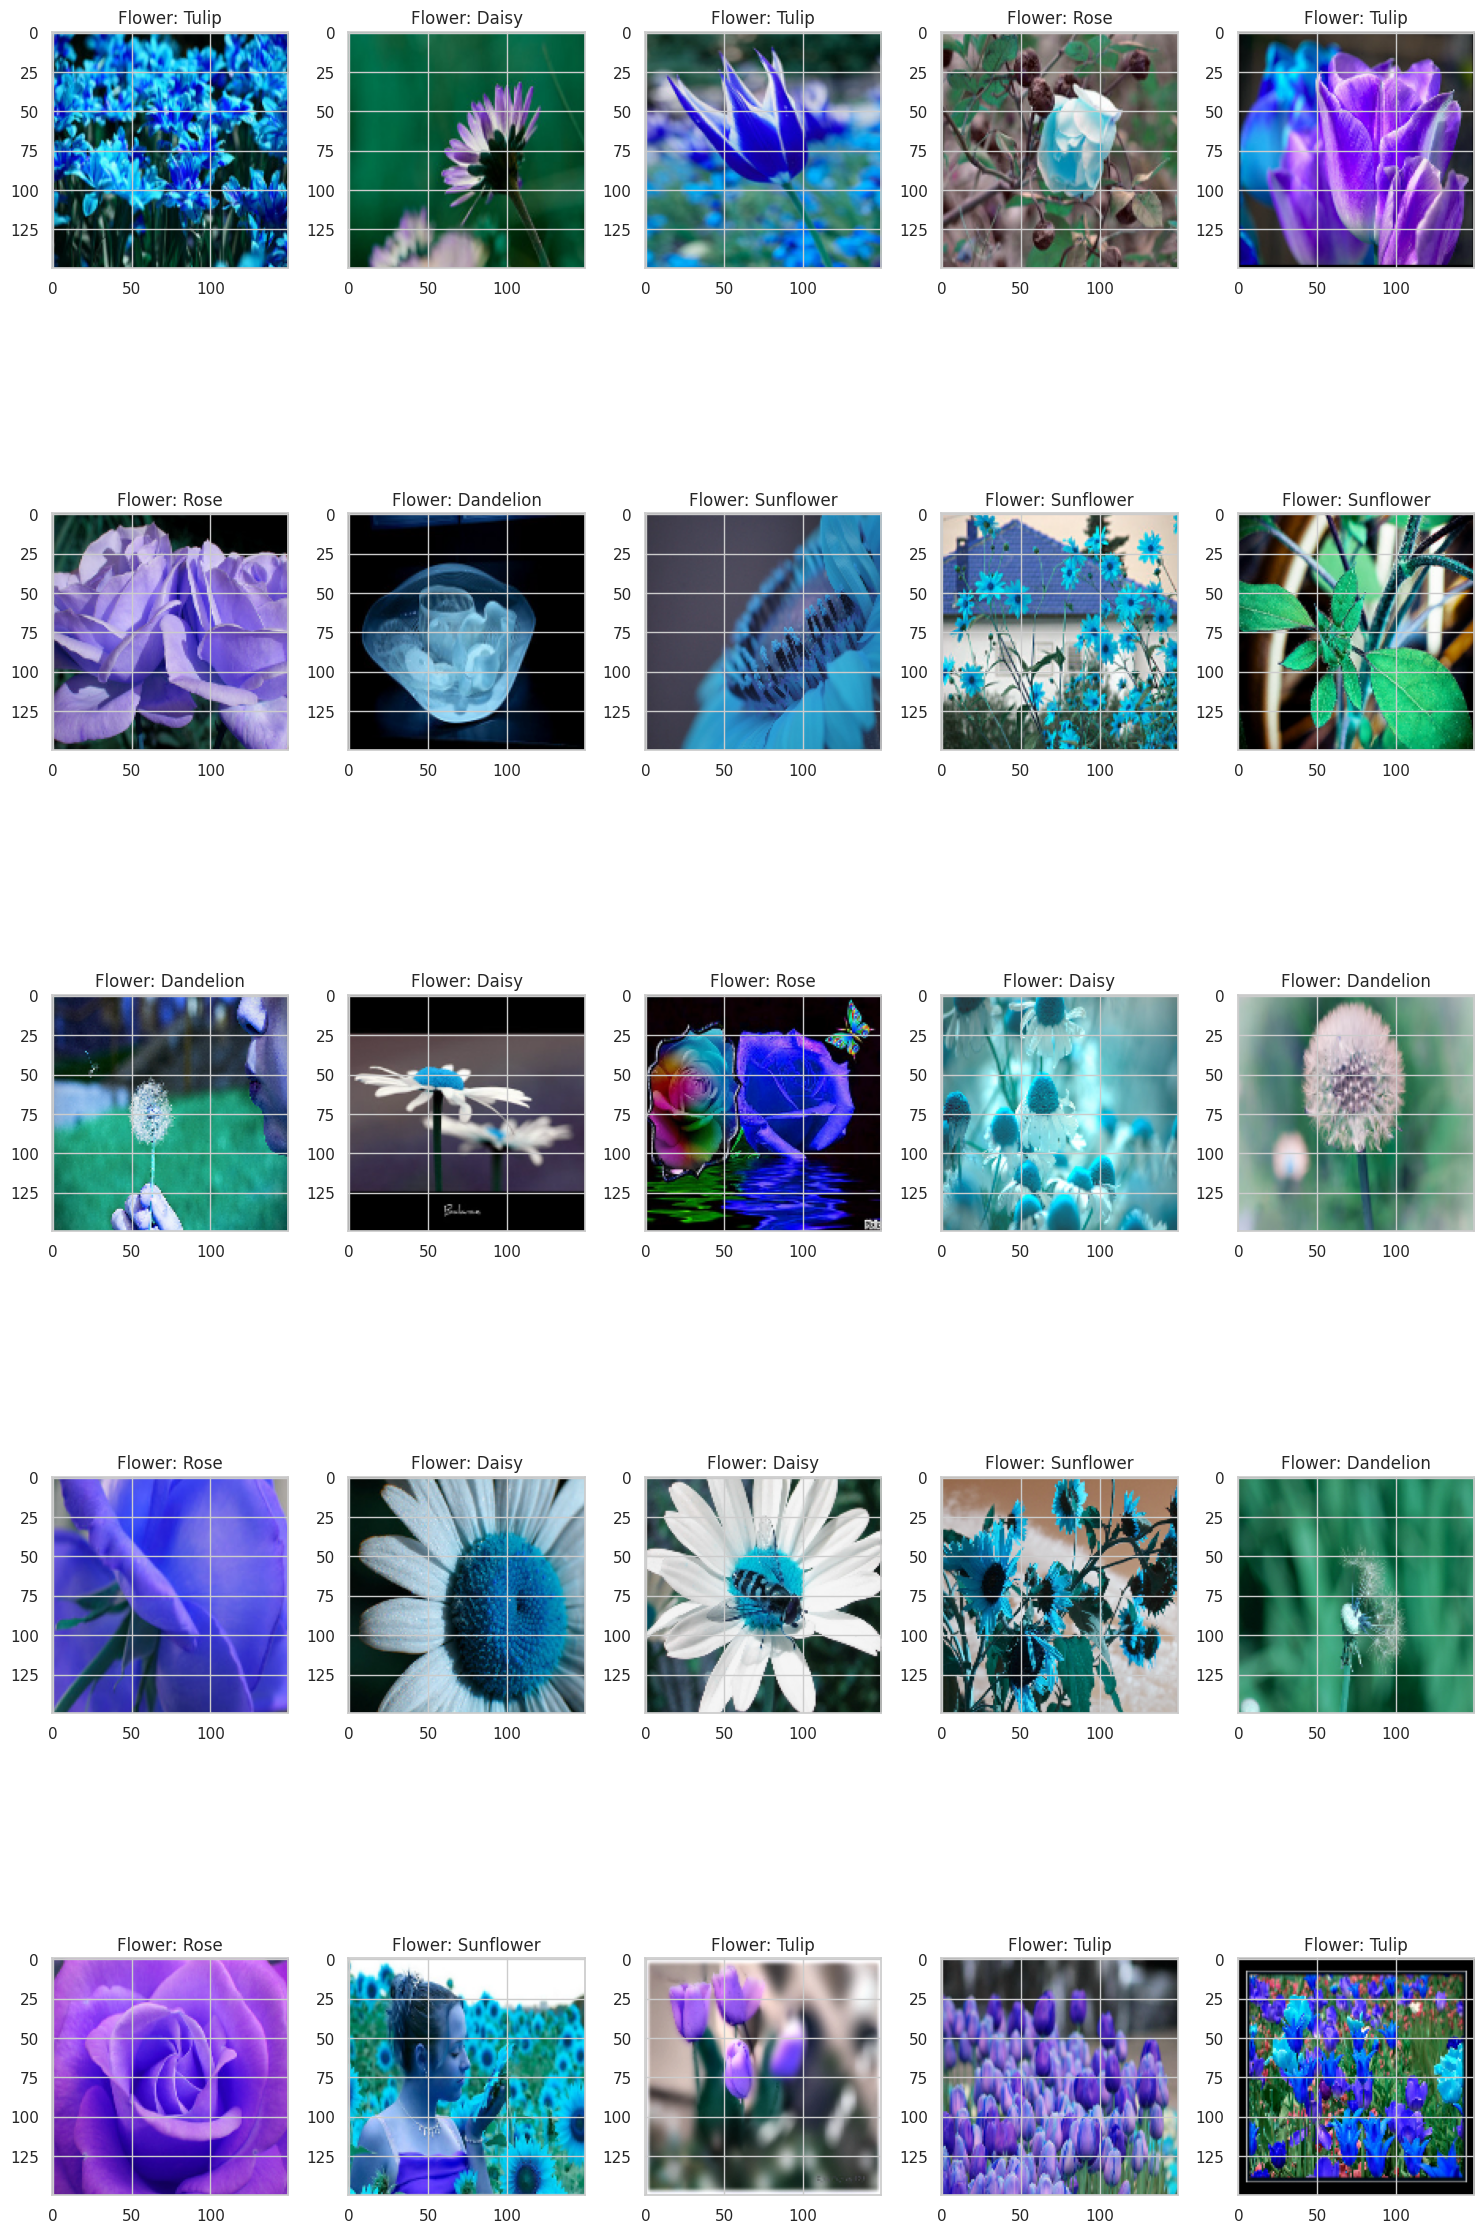

In [ ]:
fig,ax = plt.subplots(5,5)
fig.set_size_inches(15,25)
for i in range(5):
    for j in range(5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()

# 2.3) Label Encoding the Y array(i.e. Daisy->0,Rose->1,etc..)&then One Hot Encoding

In [ ]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y,5)
X = np.array(X)
X = X/255

# 2.4) Splitting into Training and Validation Sets

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(X,Y,
                                                 test_size =0.25,random_state=45)

# 2.5)Setting the Random Seeds

In [ ]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

# 3) Modelling

3.1) Building the ConvNet Model

In [ ]:
# modelling starts using a CNN

model = Sequential()

model.add(
    Conv2D(filters=32,kernel_size=(5,5),
    padding = 'same', activation='relu',
    input_shape =(150,150,3)))

model.add(MaxPooling2D(pool_size=(2,2)))


model.add(
    Conv2D(filters = 64,kernel_size = (3,3)
    ,padding = 'same',activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


model.add(
    Conv2D(filters = 96, kernel_size =(3,3),
          padding = 'same',activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(
    Conv2D(filters = 96,kernel_size=(3,3),
          padding = 'same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation= 'softmax'))

# 3.2) Using Callbacks

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1)
early_stop = EarlyStopping(monitor='val_accuracy',verbose=1)
checkpoint = ModelCheckpoint('best_model.h5',monitor='val_accuracy',save_best_only=True,verbose=1)


# 3.3)Data Augmentation to prevent Overfitting

In [ ]:
datagen = ImageDataGenerator(

    featurewise_center=False,           # Don't subtract the mean of the whole dataset

    samplewise_center=False,            # Don't subtract the mean of each sample

    featurewise_std_normalization=False,# Don't divide by std of whole dataset

    samplewise_std_normalization=False, # Don't divide each image by its std

    zca_whitening=False,                # Don't apply ZCA whitening (expensive and rarely needed)

    rotation_range=10,                  # Rotate images randomly within [-10°, +10°]

    zoom_range=0.1,                     # Randomly zoom in/out up to ±10%

    width_shift_range=0.2,              # Shift image left/right up to ±20% of width

    height_shift_range=0.2,             # Shift image up/down up to ±20% of height

    horizontal_flip=True,               # Flip images left-right randomly

    vertical_flip=False )               # No up-down flipping

datagen.fit(x_train)

# 3.4)Compiling the Keras Model & Summary

In [ ]:

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7776)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,981,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,143,749 (15.81 MB)

 Trainable params: 4,143,749 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

# 3.5)Fitting on the Training set and making predcitions on the Validation set

In [ ]:
batch_size = 256
steps_per_epoch = x_train.shape[0] // batch_size

History = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    epochs=50,
    steps_per_epoch=steps_per_epoch,
   # callbacks=[lr_reduction, checkpoint],
    verbose=1
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9028 - loss: 0.2758 - val_accuracy: 0.8083 - val_loss: 0.6225
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9141 - loss: 0.2249 - val_accuracy: 0.8102 - val_loss: 0.6213
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9283 - loss: 0.2106 - val_accuracy: 0.8287 - val_loss: 0.5994
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9258 - loss: 0.2162 - val_accuracy: 0.8269 - val_loss: 0.5959
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9430 - loss: 0.1646 - val_accuracy: 0.8306 - val_loss: 0.5952
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9336 - loss: 0.1751 - val_accuracy: 0.8306 - val_loss: 0.5973
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9421 - loss: 0.1625 - val_accuracy: 0.8370 - val_loss: 0.6103
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9336 - loss: 0.1694 - val_accuracy: 0.8370 - val_l

# 4 ) Evaluating the Model Performance

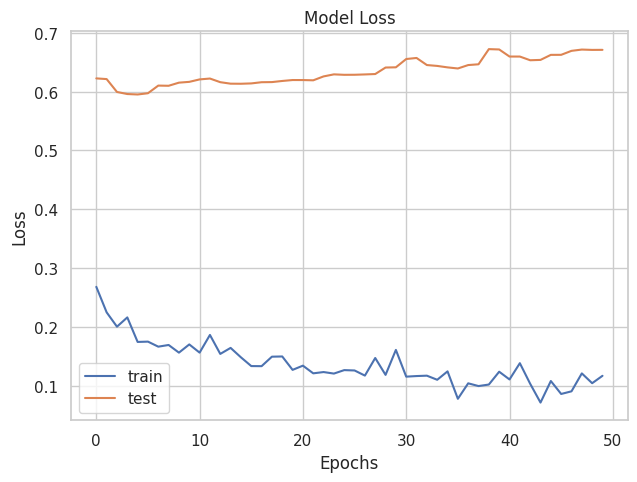

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

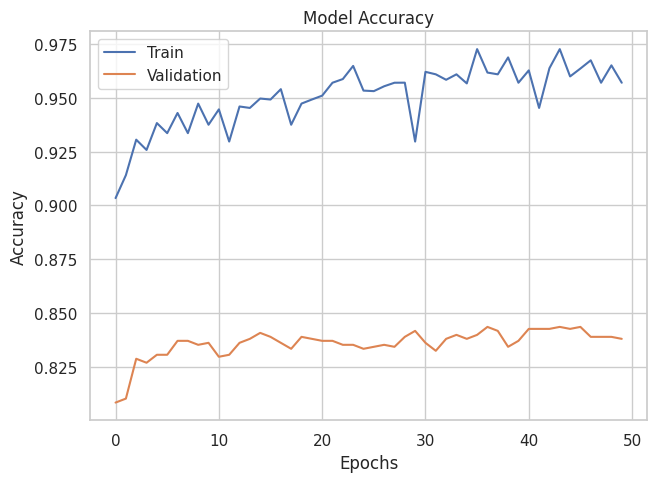

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

# 5 ) Visualizing Predictons on the Validation Set

In [ ]:
# Predict probabilities for test set
y_pred_prob = model.predict(x_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot true labels to class indices
y_true = np.argmax(y_test, axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [ ]:
# Evaluate on training set
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)

# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# Precision (macro = average over all classes)
prec = precision_score(y_true, y_pred, average='macro')

# Recall
rec = recall_score(y_true, y_pred, average='macro')


# Print results
print(f"Training Accuracy:   {train_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")

Training Accuracy:   0.9852
Test Accuracy:       0.8380
Precision: 0.8380
Recall:    0.8417


In [ ]:
# 1. Evaluate overall metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# 2. Print a nice report
print(" Evaluation Report:")
print("=" * 30)
print(f" Accuracy :  {acc:.4f}")
print(f" Precision:  {prec:.4f}")
print(f" Recall   :  {rec:.4f}")
print(f" F1-Score :  {f1:.4f}")
print("=" * 30)

# 3. Detailed per-class report
print("\n Classification Report (Per Class):")
print(classification_report(y_true, y_pred, target_names=le.classes_))

 Evaluation Report:
 Accuracy :  0.8380
 Precision:  0.8380
 Recall   :  0.8417
 F1-Score :  0.8392

 Classification Report (Per Class):
              precision    recall  f1-score   support

       Daisy       0.87      0.88      0.88       186
   Dandelion       0.88      0.85      0.86       260
        Rose       0.74      0.79      0.77       206
   Sunflower       0.86      0.92      0.88       189
       Tulip       0.83      0.77      0.80       239

    accuracy                           0.84      1080
   macro avg       0.84      0.84      0.84      1080
weighted avg       0.84      0.84      0.84      1080



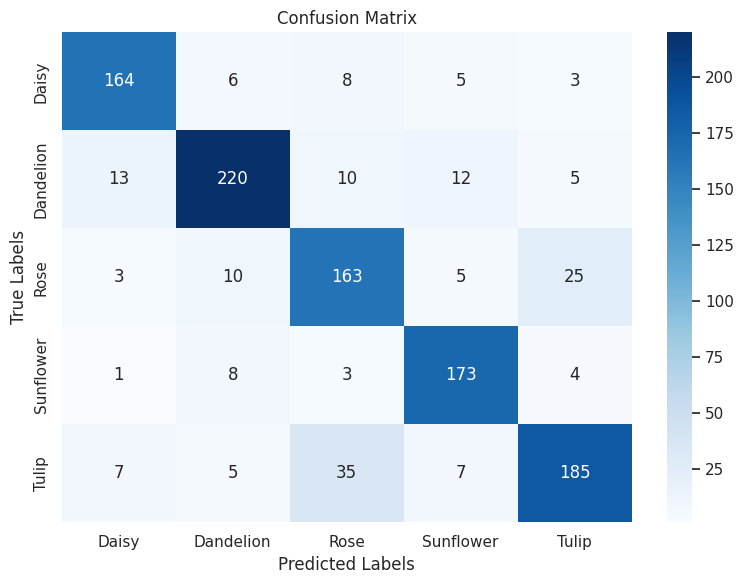

In [ ]:
cm = confusion_matrix(y_true, y_pred)
class_names = le.classes_  # if using LabelEncoder

# Step 3: Plot as heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

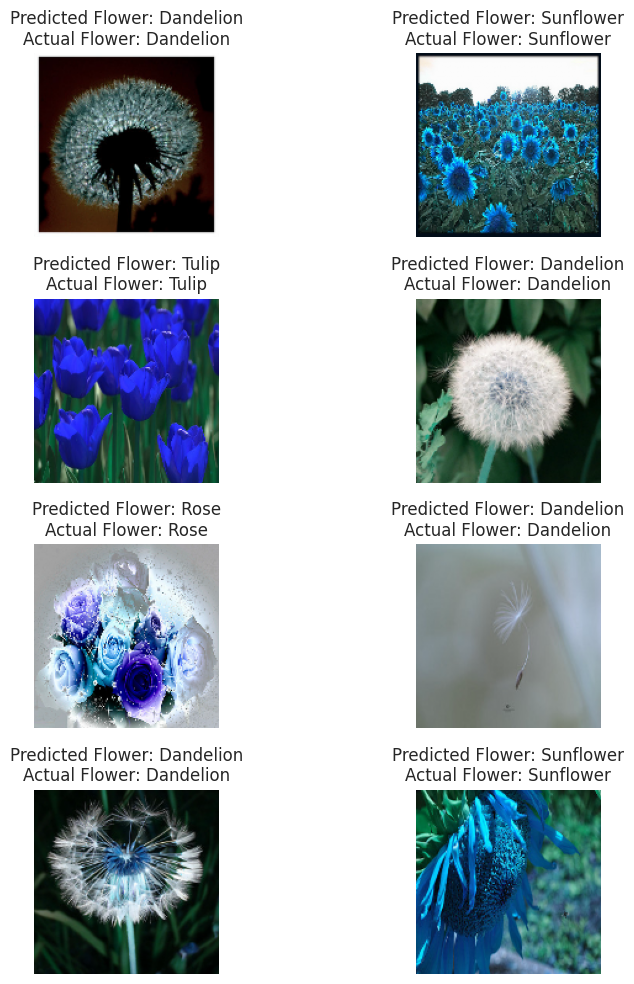

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(10, 10)

for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[prop_class[count]])

        predicted_label = le.inverse_transform([y_pred[prop_class[count]]])[0]
        actual_label = le.inverse_transform([np.argmax(y_test[prop_class[count]])])[0]

        ax[i, j].set_title(f"Predicted Flower: {predicted_label}\nActual Flower: {actual_label}")
        ax[i, j].axis('off')

        count += 1

plt.tight_layout()
plt.show()


CORRECTLY CLASSIFIED FLOWER IMAGES